In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
File = pd.read_csv(r'C:\Users\rohishah\Desktop\ML_Hackathon\predict_stores.csv')
File.columns
File['pop_2009'] = File['pop_2009']/1000
File['per_capita_09'] = File['per_capita_09']/1000

In [3]:
selected_features = ['pop_2009','per_capita_09']
target = ["PCH_GROC_09_14"]

In [4]:
Stores_data_frame = File[['pop_2009','RECFAC09','PCT_LACCESS_POP10',
                     'METRO13','per_capita_09','PCT_LACCESS_LOWI10',
                     'PCT_LACCESS_HHNV10','FFR09','FSR09',"PCH_GROC_09_14"]]

In [5]:
Stores_data_frame.head()

,pop_2009,RECFAC09,PCT_LACCESS_POP10,METRO13,per_capita_09,PCT_LACCESS_LOWI10,PCT_LACCESS_HHNV10,FFR09,FSR09,PCH_GROC_09_14
0,28.7,4,6.8,1,29.1,3.3,2.6,6,7,True
1,8.3,0,12.4,0,24.5,7.0,3.2,5,3,False
2,72.6,16,33.7,0,59.7,8.6,2.1,71,186,False
3,54.2,6,14.4,1,30.3,5.1,1.4,52,37,False
4,72.7,13,24.8,1,41.8,7.5,2.6,47,54,False


In [6]:
Stores_data_frame = Stores_data_frame.fillna(0.0)

In [7]:
def preprocess_features(Stores_data_frame):
    selected_featur = Stores_data_frame[selected_features]
    processed_features = selected_featur.copy()
     # Create a synthetic feature.
    return processed_features

In [8]:
def preprocess_targets(Stores_data_frame):
    output_targets = pd.DataFrame()
    output_targets[target] =Stores_data_frame[target] 
    return output_targets

In [9]:
training_examples = preprocess_features(Stores_data_frame.head(2000))
training_targets = preprocess_targets(Stores_data_frame.head(2000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(Stores_data_frame.tail(1086))
validation_targets = preprocess_targets(Stores_data_frame.tail(1086))

In [10]:
training_examples.head()

,pop_2009,per_capita_09
0,28.7,29.1
1,8.3,24.5
2,72.6,59.7
3,54.2,30.3
4,72.7,41.8


In [11]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [12]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [13]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
  
  # Create a linear classifier object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
    linear_classifier = tf.estimator.DNNClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer,
    hidden_units = [10,10])
  
  # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["PCH_GROC_09_14"], 
                                          batch_size=batch_size, 
                                                  shuffle=False)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["PCH_GROC_09_14"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["PCH_GROC_09_14"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
    print ("Training model...")
    training_log_losses = []
    validation_log_losses = []
    for period in range (0, periods):
        
        linear_classifier.train(input_fn=training_input_fn,
                                steps=steps_per_period)
       # Take a break and compute predictions.
        
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])

        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])

        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        # Occasionally print the current loss.
        print(period, training_log_loss)
        # Add the loss metrics from this period to our list.
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
   
    print ("Model training finished.")
  
  # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return linear_classifier

Training model...
0 0.583660548531
1 0.594828444719
2 0.597612620264
3 0.599822713912
4 0.600823152483
5 0.601197024435
6 0.601277110055
7 0.601175942034
8 0.600973122165
9 0.600541844651
Model training finished.


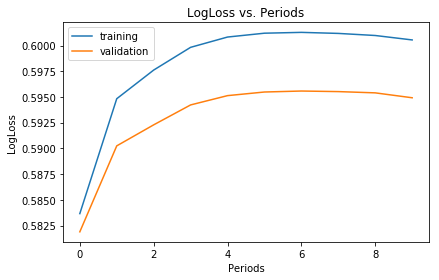

In [14]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    steps=500,
    batch_size=1,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [15]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["PCH_GROC_09_14"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

In [16]:
evaluation_metrics['auc']

0.6236515

In [17]:
evaluation_metrics['accuracy']

0.72283608

In [18]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

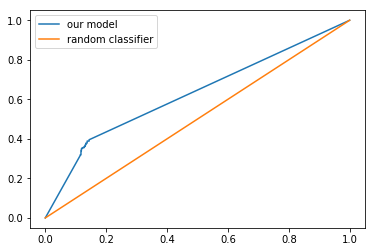

In [19]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)